In [1]:
%matplotlib inline

import scipy.stats as st
import numpy as np
import pandas as pd
import matplotlib

import re
import time

import matplotlib.pyplot as plt
import datetime
from collections import Counter

In [2]:
np.random.seed(45873)

TIMESTAMP_FORMAT='%Y-%m-%d,%H:%M:%S,%Z'
DATAFRAME_DATETIME_FORMAT="%Y-%m-%d %H:%M:%S" 
    
laptops=["riccardo", "valentina", "michela"]
test_folders=["test1","test2","test3"]

DATA_FOLDER="data"
laptop_tests = dict()

In [3]:

class EliotTest:   
    """Eliot test holds are information related to a single test case"""

    step_down = 0
    
    def __init__(self, timestamp_start, test_number, delta_seconds, step_up, step_down):
        self.timestamp_start = time.strptime(timestamp_start, TIMESTAMP_FORMAT)
        self.test_number = int(test_number)
        self.delta_seconds = int(delta_seconds)
        self.step_up = int(step_up)
        if step_down != "":
            self.step_down = int(step_down)
        
    def set_end(self, timestamp_end):
        self.timestamp_end = time.strptime(timestamp_end, TIMESTAMP_FORMAT)
    
    def set_timestamp_scaling_start(self, timestamp_scaling_start):
        self.timestamp_scaling_start = time.strptime(timestamp_scaling_start, TIMESTAMP_FORMAT)

    def __str__(self):
        return "Test {}: start_time: {}, end_time: {}, delta: {} seconds, step_up: {}, step_down: {}".format(self.test_number, self.timestamp_start, self.timestamp_end, self.delta_seconds, self.step_up, self.step_down)

    def set_data(self, dataframe):
        self.data = dataframe
        
    def short_desc(self):
        return "Test {}".format(self.test_number)
    
def parse_logs(test_folders, data_folder):
    """Utility function that return a group of test cases for a given set of  EliotTest resources"""
    tests = dict()

    pattern_start="(.*) Starting test ([0-9]+): delta: ([0-9]+) seconds, step_up ([0-9]+), step_down: ([0-9]*)"
    pattern_starting_scaling="(.*) Starting scaling"
    pattern_end="(.*) Test [0-9]+ stabilization period elapsed, test completed"

    for folder in test_folders:
        cases = list()
        with open(data_folder +"/"+ folder+"/test.log") as f:
            line = f.readline()
            test = None
            while line != "":            
                match_start = re.findall(pattern_start, line)
                match_starting_scaling = re.search(pattern_starting_scaling, line)
                match_end = re.search(pattern_end, line)
                
                if match_start:
                    test = EliotTest(*match_start[0])
                elif match_starting_scaling:
                    if test is not None:
                        test.set_timestamp_scaling_start(match_starting_scaling.group(1))
                elif match_end:  
                    if test is not None:
                        test.set_end(match_end.group(1))
                        cases.append(test)
                line = f.readline()
        tests[folder]= cases                  
    return tests
        
def test_log_parsing(tests):
    for key, val in tests.items():
        print(key)
        for case in val:
            print(case)

# Retrieve all test information from the logs
for laptop in laptops:
    laptop_tests[laptop] = parse_logs(test_folders, DATA_FOLDER + "/" + laptop)
    test_log_parsing(laptop_tests[laptop])

test1
Test 1: start_time: time.struct_time(tm_year=2020, tm_mon=8, tm_mday=25, tm_hour=15, tm_min=3, tm_sec=56, tm_wday=1, tm_yday=238, tm_isdst=1), end_time: time.struct_time(tm_year=2020, tm_mon=8, tm_mday=25, tm_hour=15, tm_min=12, tm_sec=49, tm_wday=1, tm_yday=238, tm_isdst=1), delta: 10 seconds, step_up: 50, step_down: 0
Test 2: start_time: time.struct_time(tm_year=2020, tm_mon=8, tm_mday=25, tm_hour=15, tm_min=12, tm_sec=49, tm_wday=1, tm_yday=238, tm_isdst=1), end_time: time.struct_time(tm_year=2020, tm_mon=8, tm_mday=25, tm_hour=15, tm_min=22, tm_sec=9, tm_wday=1, tm_yday=238, tm_isdst=1), delta: 20 seconds, step_up: 50, step_down: 0
Test 3: start_time: time.struct_time(tm_year=2020, tm_mon=8, tm_mday=25, tm_hour=15, tm_min=22, tm_sec=9, tm_wday=1, tm_yday=238, tm_isdst=1), end_time: time.struct_time(tm_year=2020, tm_mon=8, tm_mday=25, tm_hour=15, tm_min=31, tm_sec=29, tm_wday=1, tm_yday=238, tm_isdst=1), delta: 10 seconds, step_up: 100, step_down: 0
Test 4: start_time: time.st

In [4]:
# Retrieve and store container startup times
laptops_container_startup_times = dict()
for laptop in laptops:
    container_startup_times = dict()
    for test in test_folders:
        container_startup_times[test] = pd.read_csv(DATA_FOLDER + "/" + laptop +"/" + test+"/containerStartupTime.csv")
    laptops_container_startup_times[laptop] = container_startup_times

In [5]:
for laptop in laptops:
    for folder in test_folders:
        for test_case in laptop_tests[laptop][folder]:
            start_datetime = test_case.timestamp_scaling_start
            end_datetime = test_case.timestamp_end
            containers_startup_time = laptops_container_startup_times[laptop][folder]
            mask = (containers_startup_time['Time'] > time.strftime(DATAFRAME_DATETIME_FORMAT, start_datetime)) & (containers_startup_time['Time'] <= time.strftime(DATAFRAME_DATETIME_FORMAT, end_datetime))
            data = containers_startup_time.loc[mask].fillna(0)
            data['Time'] = pd.to_datetime(containers_startup_time['Time'], format=DATAFRAME_DATETIME_FORMAT)    
            test_case.set_data(data)
            print(test_case.data.head())    

                  Time    0s   1s    2s    3s    4s    5s   6s   7s   8s
58 2020-08-25 15:04:15  18.0  2.0  13.0   2.0   0.0   0.0  0.0  0.0  0.0
59 2020-08-25 15:04:30  19.0  8.0  22.0  13.0   8.0   0.0  0.0  0.0  0.0
60 2020-08-25 15:04:45  19.0  8.0  22.0  13.0  30.0  10.0  0.0  0.0  0.0
61 2020-08-25 15:05:00  19.0  8.0  22.0  13.0  30.0  10.0  0.0  0.0  0.0
62 2020-08-25 15:05:15  19.0  8.0  22.0  13.0  30.0  10.0  0.0  0.0  0.0
                  Time    0s   1s    2s    3s    4s   5s   6s   7s   8s
95 2020-08-25 15:13:30   2.0  0.0   0.0   0.0   0.0  0.0  0.0  0.0  0.0
96 2020-08-25 15:13:45  11.0  0.0   5.0  12.0   9.0  4.0  0.0  0.0  0.0
97 2020-08-25 15:14:00  11.0  0.0   6.0  14.0  17.0  4.0  0.0  0.0  0.0
98 2020-08-25 15:14:15  12.0  4.0  17.0  35.0  26.0  4.0  0.0  0.0  0.0
99 2020-08-25 15:14:30  12.0  4.0  17.0  39.0  26.0  4.0  0.0  0.0  0.0
                   Time    0s    1s   2s   3s   4s   5s    6s    7s    8s
133 2020-08-25 15:23:00   4.0   0.0  0.0  0.0  0.0  0.0 

/home/ric/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in double_scalars
/home/ric/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in double_scalars
/home/ric/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in double_scalars
/home/ric/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in double_scalars
/home/ric/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in double_scalars


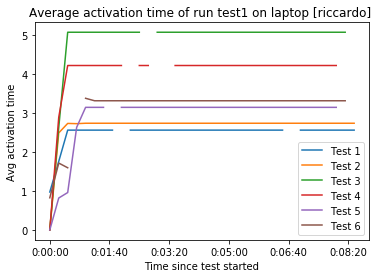

/home/ric/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in double_scalars
/home/ric/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in double_scalars


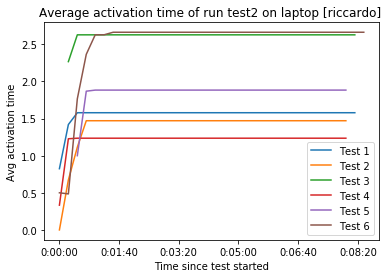

/home/ric/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in double_scalars
/home/ric/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in double_scalars


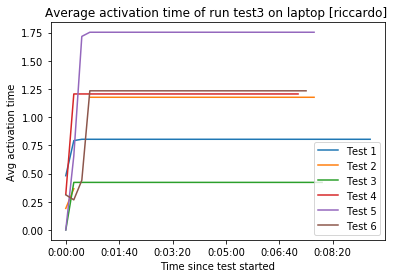

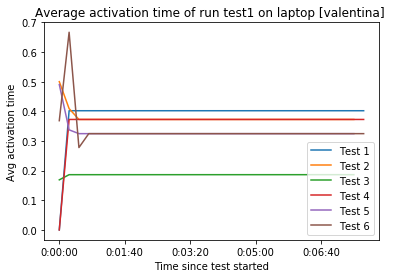

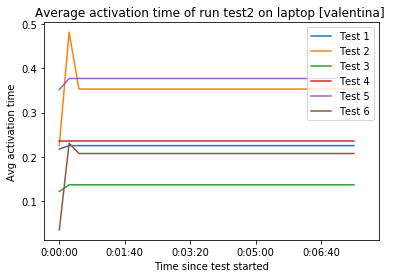

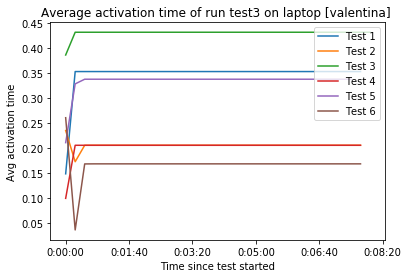

In [10]:
# Initialize counters to compute average values
avg_test = dict()
for laptop in laptops:
    avg_test[laptop] = dict()
    tests = laptop_tests[laptop]
    for test, values in tests.items():
        for test_case in values:
            avg_test[laptop][test_case.test_number] = Counter()
            
# Define
# Format timedeltas for xaxis ticks
def timeTicks(x, pos):                                                                                                                                                                                                                                                      
    d = datetime.timedelta(microseconds=x/1000)                                                                                                                                                                                                                                          
    return str(d)                                                                                                                                                                                                                                                               


for laptop in laptops:
    tests = laptop_tests[laptop]
    
    for test, values in tests.items():
        fig, ax = plt.subplots()
        for test_case in values:
            data = test_case.data
            start_datetime = test_case.timestamp_scaling_start

            y = []
            for step in range(len(data['Time'])):
                total = 0.
                sum_val = 0 
                for i in data.iloc[step][1:].index.values:
                    val = data.iloc[step][1:][i]
                    # Convert the index to the corresponding seconds; index are strings with format [0-9]*s
                    index_value = int(i.replace("s",""))
                    total += (index_value + 0.0000001) * val
                    sum_val += val
                total -= 0.0000001 * sum_val 
                avg = total / sum_val
                y.append(avg)

            
            # Add to counters to compute average
            i = 0
            for x in data['Time']- data['Time'].iloc[0]:               
                avg_test[laptop][test_case.test_number][x] += y[i]
                i += 1

            
            formatter = matplotlib.ticker.FuncFormatter(timeTicks)    
            ax.xaxis.set_major_formatter(formatter) 
            
            # Shift all data as delta from the start of the test
            plt.plot(data['Time']- data['Time'].iloc[0], y, label=test_case.short_desc())
        plt.xlabel("Time since test started")
        plt.ylabel("Avg activation time")
        plt.title("Average activation time of run {} on laptop [{}] ".format(test, laptop) )
        plt.legend()
        plt.show()
        



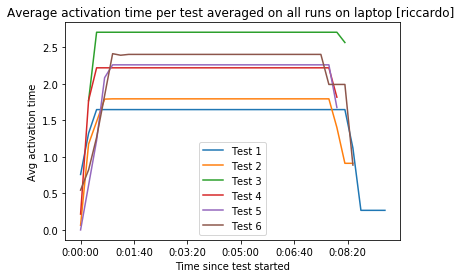

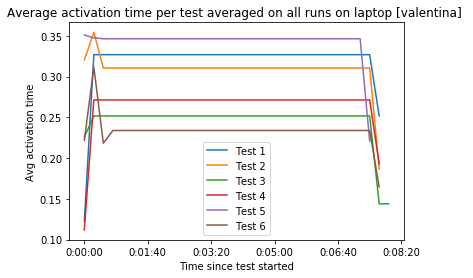

In [7]:
# Compute average value for each test case over all tests
for laptop in laptops:
    tests_number = len(tests.keys())
    for test_case, counter in avg_test[laptop].items():
        for x, y in counter.items():
            avg_test[laptop][test_case][x] = y / tests_number        
    
# Plot the computed averages    
for laptop in laptops:
    fig, ax = plt.subplots()
    for test_case, counter in avg_test[laptop].items():
        x = [x for x,y in counter.items() if str(y) != "nan"]
        y = [y for x,y in counter.items() if str(y) != "nan"]
        formatter = matplotlib.ticker.FuncFormatter(timeTicks)    
        ax.xaxis.set_major_formatter(formatter)  
        plt.plot(pd.Series(x),y, label="Test {}".format(test_case)) 

    plt.xlabel("Time since test started")
    plt.ylabel("Avg activation time")
    plt.title("Average activation time per test averaged on all runs on laptop [{}] ".format(laptop))
    plt.legend()
    plt.show()

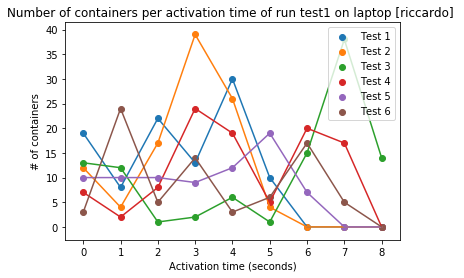

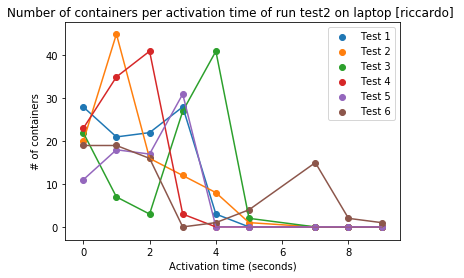

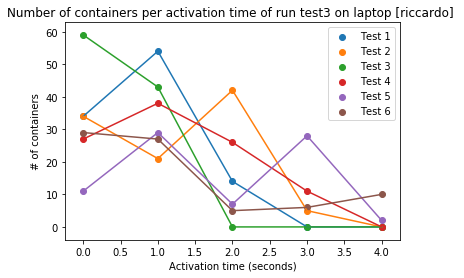

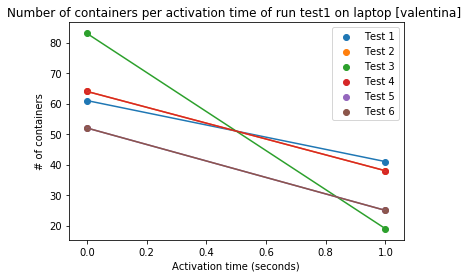

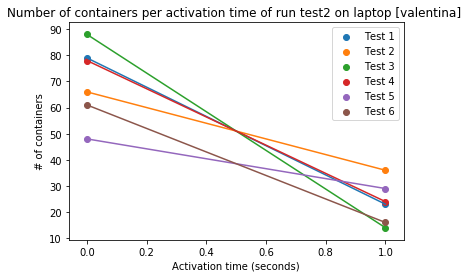

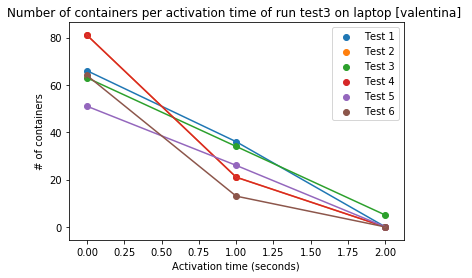

In [8]:
# Initialize counters to compute average values
avg_test = dict()
for laptop in laptops:
    avg_test[laptop] = dict()
    tests = laptop_tests[laptop]
    for test, values in tests.items():
        for test_case in values:
            avg_test[laptop][test_case.test_number] = Counter()

            
for laptop in laptops:
    tests = laptop_tests[laptop]
    for test, values in tests.items():
        fig, ax = plt.subplots()
        for test_case in values:
            data = test_case.data
            
            X = []
            Y = []

            for index in data.iloc[-1][1:].index.values:
                index_value = int(index.replace("s",""))
                X.append(index_value)
                Y.append(data.iloc[-1][index])

            X = [ x for x,y in sorted(zip(X,Y))]
            Y = [ y for x,y in sorted(zip(X,Y))]

            for x,y in zip(X,Y):
                avg_test[laptop][test_case.test_number][x] += y

            plt.scatter(X,Y, label=test_case.short_desc())
            plt.plot(X,Y)

        plt.xlabel("Activation time (seconds)")
        plt.ylabel("# of containers")
        plt.title("Number of containers per activation time of run {} on laptop [{}] ".format(test, laptop))
        plt.legend()
        plt.show()

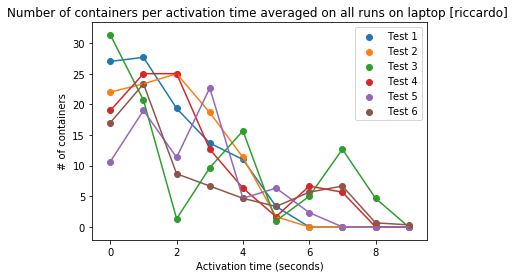

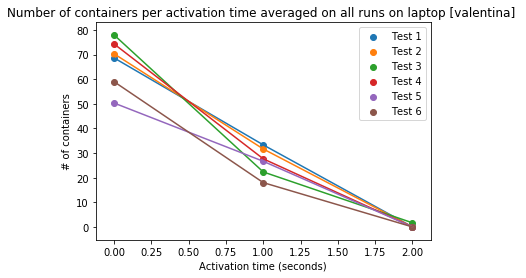

In [9]:
# Compute average value for each test case over all tests
for laptop in laptops:
    tests_number = len(tests.keys())
    for test_case, counter in avg_test[laptop].items():
        for x, y in counter.items():
            avg_test[laptop][test_case][x] = y / tests_number        
    
# Plot the computed averages    
for laptop in laptops:
    fig, ax = plt.subplots()
    for test_case, counter in avg_test[laptop].items():
        x = [x for x,y in counter.items()]
        y = [y for x,y in counter.items()]
        plt.scatter(x,y, label="Test {}".format(test_case))
        plt.plot(x,y)

    plt.xlabel("Activation time (seconds)")
    plt.ylabel("# of containers")
    plt.title("Number of containers per activation time averaged on all runs on laptop [{}] ".format(laptop))
    plt.legend()
    plt.show()